# Powergrid library construction and zero gamma data

$\Gamma = 0$,

Perburbations = large

In [77]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import coo_array

from os import path

## Loading data

#### Reading gamma values 

In [78]:
folder_name = "powergrid/Datasets/case4bus2gen/"

In [79]:
gamma_df = pd.read_csv(path.join(folder_name, "case_4bus2gen_gamma.csv"))

In [80]:
gamma_df

,gen_1,gen_2,term_1,term_2,load_1,load_2
0,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000
2,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000
3,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000
4,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000
5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000


#### Reading time series data and skipping rows to sub sample

In [81]:
data_matrix_df = pd.read_csv(path.join(folder_name, "trimmed_time_series.csv"))

skip_n_rows_btw = 100
rows_to_keep = np.arange(0, len(data_matrix_df_orig), skip_n_rows_btw)

data_matrix_df = data_matrix_df_orig.iloc[rows_to_keep].reset_index(drop=True)

In [84]:
any(data_matrix_df.duplicated(subset=['time']))

False

In [85]:
data_matrix_df

,time,PhaseGen1,PhaseGen2,PhaseGenTerm1,PhaseGenTerm2,PhaseLoad1,PhaseLoad2,FreqGen1,FreqGen2,FreqGenTerm1,...,ActivePowerGenTerm1,ActivePowerGenTerm2,ActivePowerLoad1,ActivePowerLoad2,ReactivePowerGen1,ReactivePowerGen2,ReactivePowerGenTerm1,ReactivePowerGenTerm2,ReactivePowerLoad1,ReactivePowerLoad2
0,0.00000000,0.00000000,0.03048064,0.00000000,0.03048064,0.00000000,0.00000000,0.00000000,0.00000000,-3.76991118,...,-0.00000000,1.30553432,-0.82715001,-0.47838430,0.00000000,0.00000000,0.68226515,1.40126166,-1.07708835,-1.28431796
1,0.01000000,0.00207317,0.03228481,-0.05799463,-0.04116035,-0.06907518,-0.08088508,0.38409320,0.32207273,-5.19153263,...,0.25887909,-0.09266137,-0.97515765,-1.22561386,0.01685263,0.05413882,0.70721622,1.45846000,-1.07791568,-1.27233265
2,0.02000000,0.00714632,0.03639922,-0.09755353,-0.07170918,-0.11038467,-0.12525976,0.60913700,0.48141153,-2.87931824,...,0.00431959,-0.27718714,-1.30142939,-1.56906862,0.05116939,0.11723936,0.74514915,1.54140061,-1.06778242,-1.25900967
3,0.03000000,0.01391813,0.04161200,-0.11853445,-0.08725512,-0.13241283,-0.14920139,0.73206815,0.54963974,-1.43655444,...,-0.15474827,-0.38378622,-1.49777509,-1.77850225,0.08184660,0.16651783,0.77837431,1.60565779,-1.06013534,-1.24913009
4,0.04000000,0.02158021,0.04721482,-0.12817977,-0.09388366,-0.14283237,-0.16073258,0.79225983,0.56424640,-0.56651413,...,-0.25006607,-0.44760550,-1.61575711,-1.90489358,0.10459105,0.19957296,0.80290385,1.64850497,-1.05507883,-1.24260948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,199.95010000,-1.95655998,-1.95669805,-2.13053526,-2.10006318,-2.14920717,-2.16678274,0.00363872,-0.00221294,0.00069589,...,-0.29729650,-0.48939667,-1.69997886,-2.00001998,0.14105687,0.20602536,0.84402828,1.65508171,-1.05350374,-1.23940161
19997,199.96010000,-1.95652469,-1.95671968,-2.13052857,-2.10007093,-2.14920882,-2.16678136,0.00340700,-0.00210454,0.00064024,...,-0.29725612,-0.48942949,-1.69997735,-2.00001657,0.14110313,0.20598557,0.84408266,1.65502423,-1.05350881,-1.23940611
19998,199.97010000,-1.95649205,-1.95674001,-2.13052249,-2.10007838,-2.14921057,-2.16678024,0.00311030,-0.00195496,0.00057273,...,-0.29721652,-0.48946224,-1.69997636,-2.00001290,0.14114610,0.20594862,0.84413324,1.65497072,-1.05351355,-1.23941034
19999,199.98010000,-1.95646267,-1.95675865,-2.13051715,-2.10008538,-2.14921238,-2.16677942,0.00275684,-0.00176860,0.00049516,...,-0.29717850,-0.48949421,-1.69997590,-2.00000908,0.14118499,0.20591521,0.84417906,1.65492219,-1.05351785,-1.23941422


In [6]:
new_column_names = ["time", "Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                   "om_0", "om_1","om_2", "om_3","om_4", "om_5", "P_0", "P_1", "P_2", "P_3", "P_4", "P_5",
                   "Q_0", "Q_1", "Q_2", "Q_3", "Q_4", "Q_5"]
data_matrix_df.rename(columns=dict((zip(data_matrix_df.columns, new_column_names))),
                     inplace=True)

In [7]:
data_matrix_df = data_matrix_df[["time", "Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                   "om_0", "om_1","om_2", "om_3","om_4", "om_5", "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]]

data_matrix_df

,time,Phi_0,Phi_1,Phi_2,Phi_3,Phi_4,Phi_5,om_0,om_1,om_2,om_3,om_4,om_5,P_0,P_1,P_2,P_3,P_4,P_5
0,0.00000000,0.00000000,0.03048064,0.00000000,0.03048064,0.00000000,0.00000000,0.00000000,0.00000000,-3.76991118,-15.87535473,-6.58113387,-11.47271205,-0.00000000,-0.00000000,-0.00000000,1.30553432,-0.82715001,-0.47838430
1,0.01000000,0.00207317,0.03228481,-0.05799463,-0.04116035,-0.06907518,-0.08088508,0.38409320,0.32207273,-5.19153263,-4.13083405,-5.46518256,-5.83873397,0.56095147,1.47360231,0.25887909,-0.09266137,-0.97515765,-1.22561386
2,0.02000000,0.00714632,0.03639922,-0.09755353,-0.07170918,-0.11038467,-0.12525976,0.60913700,0.48141153,-2.87931824,-2.17392585,-3.00515162,-3.24914607,0.97655598,2.16680957,0.00431959,-0.27718714,-1.30142939,-1.56906862
3,0.03000000,0.01391813,0.04161200,-0.11853445,-0.08725512,-0.13241283,-0.14920139,0.73206815,0.54963974,-1.43655444,-1.03243119,-1.52473992,-1.67005372,1.23405535,2.58075647,-0.15474827,-0.38378622,-1.49777509,-1.77850225
4,0.04000000,0.02158021,0.04721482,-0.12817977,-0.09388366,-0.14283237,-0.16073258,0.79225983,0.56424640,-0.56651413,-0.35264904,-0.63517643,-0.71708550,1.39417084,2.82415143,-0.25006607,-0.44760550,-1.61575711,-1.90489358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,199.95010000,-1.95655998,-1.95669805,-2.13053526,-2.10006318,-2.14920717,-2.16678274,0.00363872,-0.00221294,0.00069589,-0.00078551,-0.00015942,0.00015066,1.61748155,2.86921045,-0.29729650,-0.48939667,-1.69997886,-2.00001998
19997,199.96010000,-1.95652469,-1.95671968,-2.13052857,-2.10007093,-2.14920882,-2.16678136,0.00340700,-0.00210454,0.00064024,-0.00076292,-0.00017081,0.00012491,1.61774472,2.86893481,-0.29725612,-0.48942949,-1.69997735,-2.00001657
19998,199.97010000,-1.95649205,-1.95674001,-2.13052249,-2.10007838,-2.14921057,-2.16678024,0.00311030,-0.00195496,0.00057273,-0.00072490,-0.00017825,0.00009728,1.61798918,2.86867884,-0.29721652,-0.48946224,-1.69997636,-2.00001290
19999,199.98010000,-1.95646267,-1.95675865,-2.13051715,-2.10008538,-2.14921238,-2.16677942,0.00275684,-0.00176860,0.00049516,-0.00067272,-0.00018170,0.00006843,1.61821035,2.86844733,-0.29717850,-0.48949421,-1.69997590,-2.00000908


In [8]:
final_time = 20

In [9]:
data_matrix_df = data_matrix_df[data_matrix_df["time"] <= final_time]

In [10]:
data_matrix_df

,time,Phi_0,Phi_1,Phi_2,Phi_3,Phi_4,Phi_5,om_0,om_1,om_2,om_3,om_4,om_5,P_0,P_1,P_2,P_3,P_4,P_5
0,0.00000000,0.00000000,0.03048064,0.00000000,0.03048064,0.00000000,0.00000000,0.00000000,0.00000000,-3.76991118,-15.87535473,-6.58113387,-11.47271205,-0.00000000,-0.00000000,-0.00000000,1.30553432,-0.82715001,-0.47838430
1,0.01000000,0.00207317,0.03228481,-0.05799463,-0.04116035,-0.06907518,-0.08088508,0.38409320,0.32207273,-5.19153263,-4.13083405,-5.46518256,-5.83873397,0.56095147,1.47360231,0.25887909,-0.09266137,-0.97515765,-1.22561386
2,0.02000000,0.00714632,0.03639922,-0.09755353,-0.07170918,-0.11038467,-0.12525976,0.60913700,0.48141153,-2.87931824,-2.17392585,-3.00515162,-3.24914607,0.97655598,2.16680957,0.00431959,-0.27718714,-1.30142939,-1.56906862
3,0.03000000,0.01391813,0.04161200,-0.11853445,-0.08725512,-0.13241283,-0.14920139,0.73206815,0.54963974,-1.43655444,-1.03243119,-1.52473992,-1.67005372,1.23405535,2.58075647,-0.15474827,-0.38378622,-1.49777509,-1.77850225
4,0.04000000,0.02158021,0.04721482,-0.12817977,-0.09388366,-0.14283237,-0.16073258,0.79225983,0.56424640,-0.56651413,-0.35264904,-0.63517643,-0.71708550,1.39417084,2.82415143,-0.25006607,-0.44760550,-1.61575711,-1.90489358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,19.95910000,-0.36995021,-0.31878223,-0.51811109,-0.47471009,-0.52932695,-0.54959099,0.10345794,-0.03432414,0.02971064,0.00172170,0.01431607,0.01840715,1.37939395,3.11867443,-0.33099553,-0.46273280,-1.70189873,-2.00244132
1997,19.96910000,-0.36859447,-0.31932312,-0.51775268,-0.47476371,-0.52919882,-0.54939413,0.16687818,-0.07346053,0.04178066,-0.01235517,0.01127813,0.02087965,1.38861040,3.10900742,-0.33144083,-0.46191194,-1.70149581,-2.00276925
1998,19.97910000,-0.36663082,-0.32024233,-0.51727968,-0.47495493,-0.52910190,-0.54917514,0.22485195,-0.10986797,0.05259319,-0.02575334,0.00808650,0.02282883,1.40238322,3.09456320,-0.33114808,-0.46169807,-1.70107251,-2.00302777
1999,19.98910000,-0.36411914,-0.32150908,-0.51670567,-0.47527565,-0.52903738,-0.54893941,0.27631812,-0.14285816,0.06195080,-0.03821436,0.00480752,0.02422281,1.42028157,3.07579071,-0.33014513,-0.46207689,-1.70063762,-2.00321265


<Axes: >

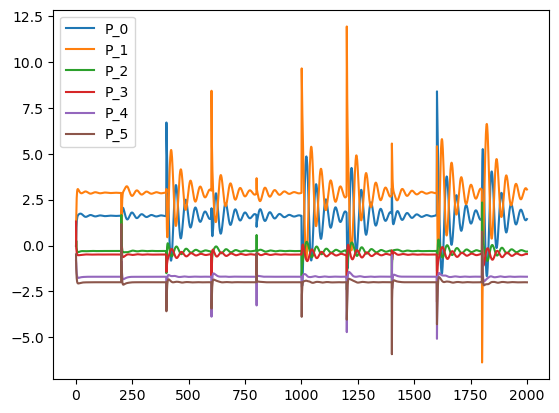

In [11]:
data_matrix_df[['P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']].plot()

<Axes: >

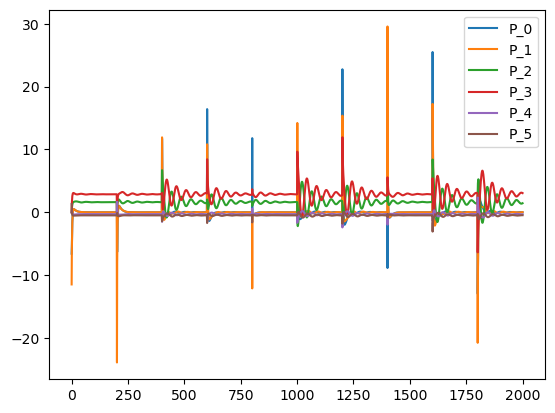

In [12]:
data_matrix_df[['P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']].plot()

<Axes: >

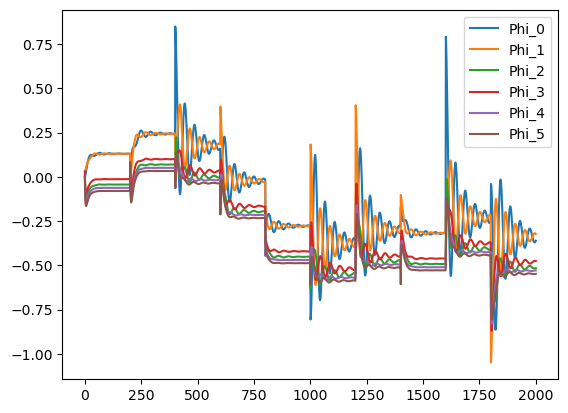

In [12]:
data_matrix_df[['Phi_0', 'Phi_1', 'Phi_2', 'Phi_3', 'Phi_4', 'Phi_5']].plot()

<Axes: >

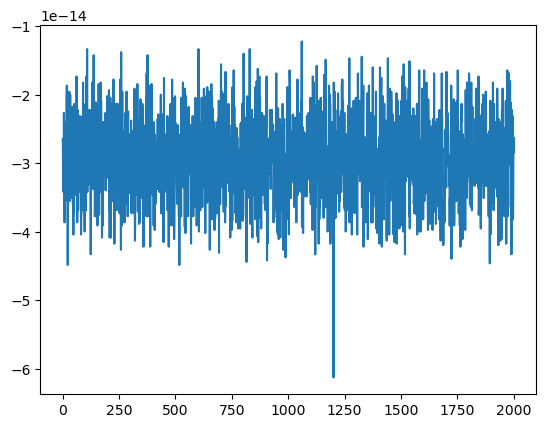

In [15]:
data_matrix_df[['P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']].sum(axis=1).plot()

In [70]:
any(data_matrix_df.duplicated(subset=['time']))

False

In [76]:
data_matrix_df[:403]

,time,Phi_0,Phi_1,Phi_2,Phi_3,Phi_4,Phi_5,om_0,om_1,om_2,om_3,om_4,om_5,P_0,P_1,P_2,P_3,P_4,P_5
0,0.00000000,0.00000000,0.03048064,0.00000000,0.03048064,0.00000000,0.00000000,0.00000000,0.00000000,-3.76991118,-15.87535473,-6.58113387,-11.47271205,-0.00000000,-0.00000000,-0.00000000,1.30553432,-0.82715001,-0.47838430
1,0.01000000,0.00207317,0.03228481,-0.05799463,-0.04116035,-0.06907518,-0.08088508,0.38409320,0.32207273,-5.19153263,-4.13083405,-5.46518256,-5.83873397,0.56095147,1.47360231,0.25887909,-0.09266137,-0.97515765,-1.22561386
2,0.02000000,0.00714632,0.03639922,-0.09755353,-0.07170918,-0.11038467,-0.12525976,0.60913700,0.48141153,-2.87931824,-2.17392585,-3.00515162,-3.24914607,0.97655598,2.16680957,0.00431959,-0.27718714,-1.30142939,-1.56906862
3,0.03000000,0.01391813,0.04161200,-0.11853445,-0.08725512,-0.13241283,-0.14920139,0.73206815,0.54963974,-1.43655444,-1.03243119,-1.52473992,-1.67005372,1.23405535,2.58075647,-0.15474827,-0.38378622,-1.49777509,-1.77850225
4,0.04000000,0.02158021,0.04721482,-0.12817977,-0.09388366,-0.14283237,-0.16073258,0.79225983,0.56424640,-0.56651413,-0.35264904,-0.63517643,-0.71708550,1.39417084,2.82415143,-0.25006607,-0.44760550,-1.61575711,-1.90489358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,3.97990000,0.24073108,0.24429019,0.06862837,0.10001550,0.05048236,0.03272061,-0.00533530,0.00518425,-0.00034647,0.00278589,0.00151595,0.00074058,1.60024500,2.88728768,-0.29931933,-0.48791407,-1.70020106,-2.00009822
399,3.98990000,0.24070328,0.24432689,0.06862994,0.10003818,0.05049667,0.03272928,-0.00024062,0.00215813,0.00065377,0.00174738,0.00134107,0.00098803,1.59997466,2.88756630,-0.29948588,-0.48774618,-1.70017787,-2.00013104
400,3.99990000,0.24072577,0.24433350,0.06864130,0.10005043,0.05050911,0.03274028,0.00470558,-0.00082239,0.00161013,0.00070331,0.00114320,0.00120722,1.60007710,2.88745433,-0.29959988,-0.48761982,-1.70015162,-2.00016011
401,4.00980000,0.84916863,0.12881931,0.04961190,-0.02518094,-0.06347181,-0.06374019,-1.68624685,-0.11600510,13.93442614,7.31108346,11.72613691,11.92137787,6.70027405,3.08042800,-1.50804705,-1.43630595,-3.25522721,-3.58112185


In [17]:
data_matrix_df.columns

Index(['time', 'Phi_0', 'Phi_1', 'Phi_2', 'Phi_3', 'Phi_4', 'Phi_5', 'om_0',
       'om_1', 'om_2', 'om_3', 'om_4', 'om_5', 'P_0', 'P_1', 'P_2', 'P_3',
       'P_4', 'P_5'],
      dtype='object')

#### Loading admittance matrix, Y

In [18]:
admittance_Y_df = pd.read_csv(path.join(folder_name, "case_4bus2gen_Y.csv"))
for column in admittance_Y_df.columns:
    admittance_Y_df[column] = admittance_Y_df[column].apply(lambda x: x.replace('i', 'j'))

In [19]:
admittance_Y_df

,gen_1,gen_2,term_1,term_2,load_1,load_2
0,0-9.3443j,0,-0+9.3443j,0,0,0
1,0,0-19.302j,0,-0+19.302j,0,0
2,-0+9.3443j,0,0-55.977j,0,0+19.841j,0+26.882j
3,0,-0+19.302j,0,0-61.805j,0+26.882j,0+15.723j
4,0,0,0+19.841j,0+26.882j,0-46.633j,0
5,0,0,0+26.882j,0+15.723j,0,0-42.502j


#### Loading static parameters

In [20]:
static_param_df = pd.read_csv(path.join(folder_name, "case_4bus2gen_staticparams.csv"))

In [21]:
static_param_df

,V,A,omega_R,D,H
0,1.00000000,1.82000000,376.99111843,50,7.28000000
1,1.02000000,3.18000000,376.99111843,50,12.72000000
2,1.00000000,-0.50000000,376.99111843,50,0.00000000
3,1.02000000,-0.80000000,376.99111843,50,0.00000000
4,0.98985198,-1.70000000,376.99111843,50,0.00000000
5,0.97876194,-2.00000000,376.99111843,50,0.00000000


#### Loading coupling matrix, K

In [22]:
coupling_K_df = pd.read_csv(path.join(folder_name, "case_4bus2gen_K.csv"))

In [23]:
coupling_K_df_labeled = coupling_K_df.set_index(coupling_K_df.columns)
coupling_K_df_labeled

,gen_1,gen_2,term_1,term_2,load_1,load_2
gen_1,0.00000000,0.00000000,10.51600000,0.00000000,0.00000000,0.00000000
gen_2,0.00000000,0.00000000,0.00000000,22.25500000,0.00000000,0.00000000
term_1,10.51600000,0.00000000,0.00000000,0.00000000,19.64000000,26.31100000
term_2,0.00000000,22.25500000,0.00000000,0.00000000,27.14100000,15.69700000
load_1,0.00000000,0.00000000,19.64000000,27.14100000,0.00000000,0.00000000
load_2,0.00000000,0.00000000,26.31100000,15.69700000,0.00000000,0.00000000


## Forming candidate library for powersystems

In [24]:
gamma_df

,gen_1,gen_2,term_1,term_2,load_1,load_2
0,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000
2,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000
3,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000
4,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000
5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000


In [25]:
gamma_matrix = gamma_df.to_numpy()
admittance_Y_matrix = admittance_Y_df.to_numpy()

gamma_matrix

array([[-3.1416,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    , -3.1416,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    , -3.1416,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , -3.1416,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    , -3.1416,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    , -3.1416]])

In [26]:
coupling_matrix_init = np.ones(admittance_Y_matrix.shape)
# coupling_matrix_init = np.zeros(admittance_Y_matrix.shape)
# coupling_matrix_init[3,:] = 1

coupling_matrix_init = np.triu(coupling_matrix_init, 0)
coupling_matrix_init
sparse_coupling_matrix_init = coo_array(coupling_matrix_init)
sparse_coupling_matrix_init.toarray()

array([[1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1.]])

### Defining the sin interaction terms 

In [27]:
from dae_finder import FeatureCouplingTransformer

def coup_fun(x,y,i,j,gam_matrix):
    return np.sin(x-y- gam_matrix[i,j])

def coup_namer(x,y,i,j,gam_matrix):
    return "sin( {}-{} -gamma_{},{} )".format(x,y,i,j)
    

dummy_tr_sin_diff = FeatureCouplingTransformer(sparse_coupling_matrix_init,
                                           coupling_func= coup_fun,
                                           coupling_namer= coup_namer,
                                           coupling_func_args={"gam_matrix":gamma_matrix},
                                              return_df=True)

In [28]:
sin_diff_library = dummy_tr_sin_diff.fit_transform(data_matrix_df.drop(["time"], axis=1))
cop_ind = dummy_tr_sin_diff.coupled_indices_list

# cop_ind

In [29]:
sin_diff_library

,"sin( Phi_0-Phi_0 -gamma_0,0 )","sin( Phi_0-Phi_1 -gamma_0,1 )","sin( Phi_0-Phi_2 -gamma_0,2 )","sin( Phi_0-Phi_3 -gamma_0,3 )","sin( Phi_0-Phi_4 -gamma_0,4 )","sin( Phi_0-Phi_5 -gamma_0,5 )","sin( Phi_1-Phi_1 -gamma_1,1 )","sin( Phi_1-Phi_2 -gamma_1,2 )","sin( Phi_1-Phi_3 -gamma_1,3 )","sin( Phi_1-Phi_4 -gamma_1,4 )",...,"sin( Phi_2-Phi_2 -gamma_2,2 )","sin( Phi_2-Phi_3 -gamma_2,3 )","sin( Phi_2-Phi_4 -gamma_2,4 )","sin( Phi_2-Phi_5 -gamma_2,5 )","sin( Phi_3-Phi_3 -gamma_3,3 )","sin( Phi_3-Phi_4 -gamma_3,4 )","sin( Phi_3-Phi_5 -gamma_3,5 )","sin( Phi_4-Phi_4 -gamma_4,4 )","sin( Phi_4-Phi_5 -gamma_4,5 )","sin( Phi_5-Phi_5 -gamma_5,5 )"
0,-0.00000735,-0.03047592,0.00000000,-0.03047592,0.00000000,0.00000000,-0.00000735,0.03047592,0.00000000,0.03047592,...,-0.00000735,-0.03047592,0.00000000,0.00000000,-0.00000735,0.03047592,0.03047592,-0.00000735,0.00000000,-0.00000735
1,-0.00000735,-0.03020705,0.06003168,0.04322005,0.07108834,0.08286313,-0.00000735,0.09015685,0.07337915,0.10118652,...,-0.00000735,-0.01683348,0.01108033,0.02288846,-0.00000735,0.02791120,0.03971428,-0.00000735,0.01180963,-0.00000735
2,-0.00000735,-0.02924873,0.10450867,0.07877380,0.11726059,0.13201955,-0.00000735,0.13355252,0.10789793,0.14625736,...,-0.00000735,-0.02584148,0.01283078,0.02770269,-0.00000735,0.03866585,0.05352500,-0.00000735,0.01487455,-0.00000735
3,-0.00000735,-0.02769033,0.13206563,0.10100073,0.14580929,0.16239710,-0.00000735,0.15946278,0.12851073,0.17314777,...,-0.00000735,-0.03127423,0.01387793,0.03066214,-0.00000735,0.04514236,0.06190667,-0.00000735,0.01678778,-0.00000735
4,-0.00000735,-0.02563181,0.14920081,0.11520748,0.16367286,0.18130451,-0.00000735,0.17449670,0.14063077,0.18890524,...,-0.00000735,-0.03428939,0.01465208,0.03254705,-0.00000735,0.04892917,0.06679914,-0.00000735,0.01789925,-0.00000735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,-0.00000735,-0.05114565,0.14761942,0.10456837,0.15870287,0.17867615,-0.00000735,0.19801153,0.15529677,0.20899262,...,-0.00000735,-0.04338738,0.01121562,0.03147470,-0.00000735,0.05458971,0.07481094,-0.00000735,0.02026266,-0.00000735
1997,-0.00000735,-0.04925142,0.14860574,0.10596989,0.15991481,0.17981626,-0.00000735,0.19712995,0.15481539,0.20833833,...,-0.00000735,-0.04297573,0.01144589,0.03163617,-0.00000735,0.05440823,0.07456117,-0.00000735,0.02019394,-0.00000735
1998,-0.00000735,-0.04637185,0.15007967,0.10811239,0.16175724,0.18153221,-0.00000735,0.19576486,0.15409613,0.20734438,...,-0.00000735,-0.04231211,0.01182195,0.03189006,-0.00000735,0.05412051,0.07415209,-0.00000735,0.02007190,-0.00000735
1999,-0.00000735,-0.04259718,0.15199511,0.11092774,0.16417168,0.18376986,-0.00000735,0.19395940,0.15316134,0.20604187,...,-0.00000735,-0.04141817,0.01233140,0.03222816,-0.00000735,0.05373584,0.07359716,-0.00000735,0.01990072,-0.00000735


In [30]:
candidate_lib = pd.concat([data_matrix_df.drop("time", axis=1), sin_diff_library], axis=1)

In [31]:
candidate_lib

,Phi_0,Phi_1,Phi_2,Phi_3,Phi_4,Phi_5,om_0,om_1,om_2,om_3,...,"sin( Phi_2-Phi_2 -gamma_2,2 )","sin( Phi_2-Phi_3 -gamma_2,3 )","sin( Phi_2-Phi_4 -gamma_2,4 )","sin( Phi_2-Phi_5 -gamma_2,5 )","sin( Phi_3-Phi_3 -gamma_3,3 )","sin( Phi_3-Phi_4 -gamma_3,4 )","sin( Phi_3-Phi_5 -gamma_3,5 )","sin( Phi_4-Phi_4 -gamma_4,4 )","sin( Phi_4-Phi_5 -gamma_4,5 )","sin( Phi_5-Phi_5 -gamma_5,5 )"
0,0.00000000,0.03048064,0.00000000,0.03048064,0.00000000,0.00000000,0.00000000,0.00000000,-3.76991118,-15.87535473,...,-0.00000735,-0.03047592,0.00000000,0.00000000,-0.00000735,0.03047592,0.03047592,-0.00000735,0.00000000,-0.00000735
1,0.00207317,0.03228481,-0.05799463,-0.04116035,-0.06907518,-0.08088508,0.38409320,0.32207273,-5.19153263,-4.13083405,...,-0.00000735,-0.01683348,0.01108033,0.02288846,-0.00000735,0.02791120,0.03971428,-0.00000735,0.01180963,-0.00000735
2,0.00714632,0.03639922,-0.09755353,-0.07170918,-0.11038467,-0.12525976,0.60913700,0.48141153,-2.87931824,-2.17392585,...,-0.00000735,-0.02584148,0.01283078,0.02770269,-0.00000735,0.03866585,0.05352500,-0.00000735,0.01487455,-0.00000735
3,0.01391813,0.04161200,-0.11853445,-0.08725512,-0.13241283,-0.14920139,0.73206815,0.54963974,-1.43655444,-1.03243119,...,-0.00000735,-0.03127423,0.01387793,0.03066214,-0.00000735,0.04514236,0.06190667,-0.00000735,0.01678778,-0.00000735
4,0.02158021,0.04721482,-0.12817977,-0.09388366,-0.14283237,-0.16073258,0.79225983,0.56424640,-0.56651413,-0.35264904,...,-0.00000735,-0.03428939,0.01465208,0.03254705,-0.00000735,0.04892917,0.06679914,-0.00000735,0.01789925,-0.00000735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,-0.36995021,-0.31878223,-0.51811109,-0.47471009,-0.52932695,-0.54959099,0.10345794,-0.03432414,0.02971064,0.00172170,...,-0.00000735,-0.04338738,0.01121562,0.03147470,-0.00000735,0.05458971,0.07481094,-0.00000735,0.02026266,-0.00000735
1997,-0.36859447,-0.31932312,-0.51775268,-0.47476371,-0.52919882,-0.54939413,0.16687818,-0.07346053,0.04178066,-0.01235517,...,-0.00000735,-0.04297573,0.01144589,0.03163617,-0.00000735,0.05440823,0.07456117,-0.00000735,0.02019394,-0.00000735
1998,-0.36663082,-0.32024233,-0.51727968,-0.47495493,-0.52910190,-0.54917514,0.22485195,-0.10986797,0.05259319,-0.02575334,...,-0.00000735,-0.04231211,0.01182195,0.03189006,-0.00000735,0.05412051,0.07415209,-0.00000735,0.02007190,-0.00000735
1999,-0.36411914,-0.32150908,-0.51670567,-0.47527565,-0.52903738,-0.54893941,0.27631812,-0.14285816,0.06195080,-0.03821436,...,-0.00000735,-0.04141817,0.01233140,0.03222816,-0.00000735,0.05373584,0.07359716,-0.00000735,0.01990072,-0.00000735


### Removing zero features

In [32]:
non_zero_column_series = (candidate_lib**2).sum() > 0.00001
non_zero_column_series
non_columns = [column for column in candidate_lib if non_zero_column_series[column]]

candidate_lib = candidate_lib[non_columns]

In [33]:
candidate_lib

,Phi_0,Phi_1,Phi_2,Phi_3,Phi_4,Phi_5,om_0,om_1,om_2,om_3,...,"sin( Phi_1-Phi_2 -gamma_1,2 )","sin( Phi_1-Phi_3 -gamma_1,3 )","sin( Phi_1-Phi_4 -gamma_1,4 )","sin( Phi_1-Phi_5 -gamma_1,5 )","sin( Phi_2-Phi_3 -gamma_2,3 )","sin( Phi_2-Phi_4 -gamma_2,4 )","sin( Phi_2-Phi_5 -gamma_2,5 )","sin( Phi_3-Phi_4 -gamma_3,4 )","sin( Phi_3-Phi_5 -gamma_3,5 )","sin( Phi_4-Phi_5 -gamma_4,5 )"
0,0.00000000,0.03048064,0.00000000,0.03048064,0.00000000,0.00000000,0.00000000,0.00000000,-3.76991118,-15.87535473,...,0.03047592,0.00000000,0.03047592,0.03047592,-0.03047592,0.00000000,0.00000000,0.03047592,0.03047592,0.00000000
1,0.00207317,0.03228481,-0.05799463,-0.04116035,-0.06907518,-0.08088508,0.38409320,0.32207273,-5.19153263,-4.13083405,...,0.09015685,0.07337915,0.10118652,0.11292848,-0.01683348,0.01108033,0.02288846,0.02791120,0.03971428,0.01180963
2,0.00714632,0.03639922,-0.09755353,-0.07170918,-0.11038467,-0.12525976,0.60913700,0.48141153,-2.87931824,-2.17392585,...,0.13355252,0.10789793,0.14625736,0.16095578,-0.02584148,0.01283078,0.02770269,0.03866585,0.05352500,0.01487455
3,0.01391813,0.04161200,-0.11853445,-0.08725512,-0.13241283,-0.14920139,0.73206815,0.54963974,-1.43655444,-1.03243119,...,0.15946278,0.12851073,0.17314777,0.18965759,-0.03127423,0.01387793,0.03066214,0.04514236,0.06190667,0.01678778
4,0.02158021,0.04721482,-0.12817977,-0.09388366,-0.14283237,-0.16073258,0.79225983,0.56424640,-0.56651413,-0.35264904,...,0.17449670,0.14063077,0.18890524,0.20645196,-0.03428939,0.01465208,0.03254705,0.04892917,0.06679914,0.01789925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,-0.36995021,-0.31878223,-0.51811109,-0.47471009,-0.52932695,-0.54959099,0.10345794,-0.03432414,0.02971064,0.00172170,...,0.19801153,0.15529677,0.20899262,0.22876491,-0.04338738,0.01121562,0.03147470,0.05458971,0.07481094,0.02026266
1997,-0.36859447,-0.31932312,-0.51775268,-0.47476371,-0.52919882,-0.54939413,0.16687818,-0.07346053,0.04178066,-0.01235517,...,0.19712995,0.15481539,0.20833833,0.22804667,-0.04297573,0.01144589,0.03163617,0.05440823,0.07456117,0.02019394
1998,-0.36663082,-0.32024233,-0.51727968,-0.47495493,-0.52910190,-0.54917514,0.22485195,-0.10986797,0.05259319,-0.02575334,...,0.19576486,0.15409613,0.20734438,0.22693830,-0.04231211,0.01182195,0.03189006,0.05412051,0.07415209,0.02007190
1999,-0.36411914,-0.32150908,-0.51670567,-0.47527565,-0.52903738,-0.54893941,0.27631812,-0.14285816,0.06195080,-0.03821436,...,0.19395940,0.15316134,0.20604187,0.22547478,-0.04141817,0.01233140,0.03222816,0.05373584,0.07359716,0.01990072


## Smoothening data and finding derivatives using splines

In [34]:
from dae_finder import add_noise_to_df

noise_perc = 0
data_matrix_df_list = [data_matrix_df]
num_time_points = len(data_matrix_df)
data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["time"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["time"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

In [35]:
from dae_finder import smooth_data

# Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix, domain_var="time", derr_order=1, noise_perc=noise_perc) for
                              data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) > 1:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
# if "time" in data_matrix_df_smooth:
#     data_matrix_df_smooth = data_matrix_df_smooth.drop("time", axis=1)

In [36]:
data_matrix_df_smooth - data_matrix_df

,time,Phi_0,Phi_1,Phi_2,Phi_3,Phi_4,Phi_5,om_0,om_1,om_2,om_3,om_4,om_5,P_0,P_1,P_2,P_3,P_4,P_5
0,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000
1,-0.00000045,-0.00000017,-0.00000014,0.00000221,0.00000206,0.00000242,0.00000268,-0.00001325,-0.00001023,-0.00006444,-0.00022377,-0.00010341,-0.00016653,-0.00002223,-0.00004423,0.00000576,0.00002489,0.00001372,0.00002209
2,-0.00000090,-0.00000055,-0.00000043,0.00000266,0.00000184,0.00000272,0.00000289,-0.00001492,-0.00000941,-0.00019852,-0.00007378,-0.00019008,-0.00017008,-0.00002985,-0.00004538,0.00002259,0.00000487,0.00002521,0.00002256
3,-0.00000135,-0.00000099,-0.00000074,0.00000191,0.00000144,0.00000205,0.00000227,-0.00001167,-0.00000498,-0.00013639,-0.00014090,-0.00014522,-0.00016828,-0.00002684,-0.00004345,0.00001472,0.00001399,0.00001926,0.00002232
4,-0.00000180,-0.00000143,-0.00000102,0.00000103,0.00000062,0.00000115,0.00000129,-0.00000680,0.00000068,-0.00012451,-0.00008451,-0.00012515,-0.00012969,-0.00002269,-0.00003247,0.00001367,0.00000769,0.00001660,0.00001720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.00000180,0.00000019,-0.00000006,0.00000005,0.00000000,0.00000003,0.00000003,0.00001183,-0.00000725,0.00000227,-0.00000258,-0.00000053,0.00000049,0.00000123,-0.00000129,-0.00000015,0.00000020,0.00000007,-0.00000006
1997,0.00000135,0.00000023,-0.00000010,0.00000006,-0.00000002,0.00000002,0.00000003,0.00000822,-0.00000512,0.00000155,-0.00000186,-0.00000042,0.00000030,0.00000156,-0.00000164,-0.00000001,0.00000007,0.00000006,-0.00000004
1998,0.00000090,0.00000020,-0.00000010,0.00000005,-0.00000002,0.00000001,0.00000002,0.00000494,-0.00000313,0.00000091,-0.00000117,-0.00000029,0.00000015,0.00000143,-0.00000150,0.00000006,-0.00000001,0.00000004,-0.00000002
1999,0.00000045,0.00000012,-0.00000006,0.00000003,-0.00000002,0.00000000,0.00000001,0.00000216,-0.00000140,0.00000039,-0.00000054,-0.00000015,0.00000005,0.00000089,-0.00000093,0.00000006,-0.00000003,0.00000002,-0.00000001


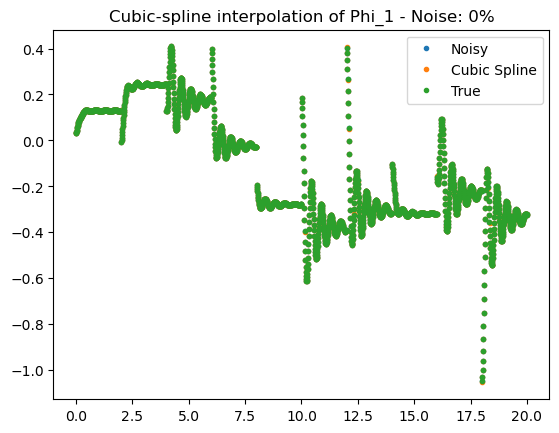

In [37]:
ind = 0
feature_ = "Phi_1"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["time"], data_matrix_df_list[ind][feature_], ".",
         data_matrix_smooth_df_list[ind]["time"],
         data_matrix_smooth_df_list[ind][feature_], ".",
         data_matrix_df[ind * num_time_points:(ind + 1) * num_time_points]["time"],
         data_matrix_df[ind * num_time_points:(ind + 1) * num_time_points][feature_], ".")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

### Removing some of the outliers coming from sudden jump during perturbations


<Axes: >

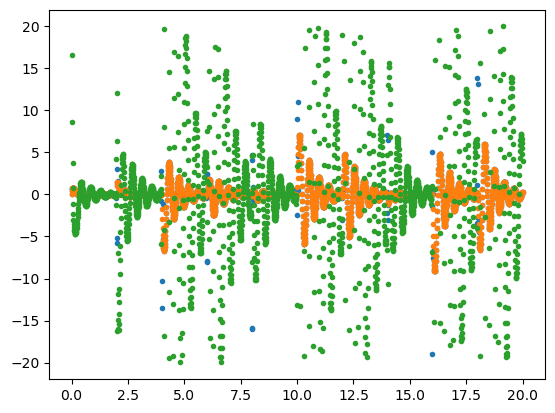

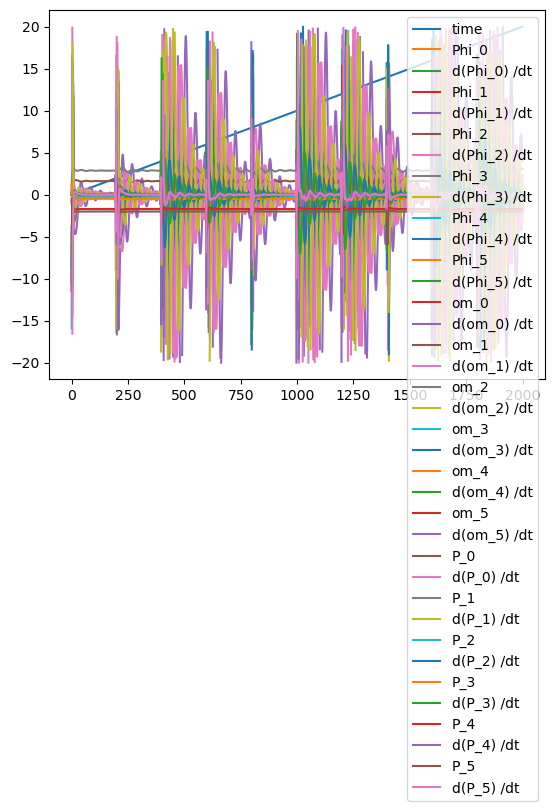

In [38]:
new_df = data_matrix_df_smooth_appended[abs(data_matrix_df_smooth_appended) <= 20]

plt.plot(new_df[["time"]], new_df[["d(Phi_0) /dt"]], ".",
         new_df[["time"]], new_df[["om_0"]], ".",
         new_df[["time"]], new_df[["d(om_0) /dt"]], ".")

new_df.plot()

## Finding Algebraic relationship

### Using sympy to find factors of redundant feature and refine the library

In [39]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [40]:
refined_candid_lib = data_matrix_df_smooth_appended[['Phi_0', 'Phi_1', 'Phi_2', 'Phi_3', 'Phi_4', 'Phi_5', 'om_0',
                                                     'om_1', 'om_2','om_3','om_4','om_5', 'P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']]

In [41]:
from sklearn.preprocessing import StandardScaler

s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_refined_lib = pd.DataFrame(s_scaler.fit_transform(refined_candid_lib), columns=s_scaler.feature_names_in_)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib), columns=s_scaler.feature_names_in_)

# Using Lasso

## Finding the conservation laws

In [42]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       alpha=0.3,
                                       fit_intercept=True)

In [52]:
candidate_lib = candidate_lib.drop(columns=['om_2','om_3','om_4','om_5'])

In [90]:
features_to_fit_ = ["Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                    "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
# features_to_fit_ = ["P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
num_nodes = 6
power_features = ["P_{}".format(ind) for ind in range(num_nodes)]
# Mapping each power feature to possible expressions in the algebraic relationship
feature_to_libr_map = {power_feat: candidate_lib.columns.drop(power_features) for power_feat in power_features}

algebraic_model_lasso.fit(candidate_lib, scale_columns=True,
                          features_to_fit=features_to_fit_,
                          feature_to_library_map=feature_to_libr_map)

AlgModelFinder(alpha=0.3, fit_intercept=True)

In [88]:
sin_diff_library.columns

Index(['sin( Phi_0-Phi_0 -gamma_0,0 )', 'sin( Phi_0-Phi_1 -gamma_0,1 )',
       'sin( Phi_0-Phi_2 -gamma_0,2 )', 'sin( Phi_0-Phi_3 -gamma_0,3 )',
       'sin( Phi_0-Phi_4 -gamma_0,4 )', 'sin( Phi_0-Phi_5 -gamma_0,5 )',
       'sin( Phi_1-Phi_1 -gamma_1,1 )', 'sin( Phi_1-Phi_2 -gamma_1,2 )',
       'sin( Phi_1-Phi_3 -gamma_1,3 )', 'sin( Phi_1-Phi_4 -gamma_1,4 )',
       'sin( Phi_1-Phi_5 -gamma_1,5 )', 'sin( Phi_2-Phi_2 -gamma_2,2 )',
       'sin( Phi_2-Phi_3 -gamma_2,3 )', 'sin( Phi_2-Phi_4 -gamma_2,4 )',
       'sin( Phi_2-Phi_5 -gamma_2,5 )', 'sin( Phi_3-Phi_3 -gamma_3,3 )',
       'sin( Phi_3-Phi_4 -gamma_3,4 )', 'sin( Phi_3-Phi_5 -gamma_3,5 )',
       'sin( Phi_4-Phi_4 -gamma_4,4 )', 'sin( Phi_4-Phi_5 -gamma_4,5 )',
       'sin( Phi_5-Phi_5 -gamma_5,5 )'],
      dtype='object')

In [54]:
algebraic_model_lasso.best_models()

,P_1,P_0,Phi_5,Phi_4,Phi_3,Phi_2,Phi_1,Phi_0,P_2,P_3,P_5,P_4
Phi_0,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00853858,0.00000000,NaN,0.00000000,-0.00000000,-0.00000000,-0.00000000
Phi_1,0.00000000,-0.00000000,0.00000000,0.00000000,0.14745980,0.00000000,NaN,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000
Phi_2,-0.00000000,0.00000000,0.23454036,0.00000000,0.00000000,NaN,0.00000000,0.68902300,0.00000000,0.00000000,0.00000000,-0.00000000
Phi_3,0.00000000,-0.00000000,0.00000000,0.19307318,NaN,0.00000000,0.71053545,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000
Phi_4,0.00000000,-0.00000000,0.46518440,NaN,0.55203833,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000
Phi_5,-0.00000000,0.00000000,NaN,0.50621442,0.00000000,0.69093133,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
om_0,0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000,0.00616439,0.00000000,0.00000000
om_1,-0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000
"sin( Phi_0-Phi_1 -gamma_0,1 )",-0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000
"sin( Phi_0-Phi_2 -gamma_0,2 )",-0.00000000,6.54098071,0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,0.02404974,0.00000000,-0.67546048,-0.00000000,-0.00000000


In [155]:
feature_to_libr_map['P_5'] = ['sin( Phi_2-Phi_5 -gamma_2,5 )', 'sin( Phi_3-Phi_5 -gamma_3,5 )']
# feature_to_libr_map['P_5'] = ['sin( Phi_1-Phi_2 -gamma_1,2 )']


In [156]:
feat = "P_5"
algebraic_model_lasso.best_models()[feat][abs(algebraic_model_lasso.best_models()[feat])>0.1]

sin( Phi_4-Phi_5 -gamma_4,5 )   -2.46200305
r2- metric                       0.10446443
Name: P_5, dtype: float64

In [195]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.linear_model import Ridge

In [210]:
lin_mod = LinearRegression()
lasso_mode = Lasso(alpha=0.05)

ridge_mode = Ridge(alpha=0.3)

In [187]:
lin_mod.fit(X=candidate_lib[feature_to_libr_map['P_5']], y=candidate_lib['P_5'])
lin_mod.score(X=candidate_lib[feature_to_libr_map['P_5']], y=candidate_lib['P_5'])

1.0

In [188]:
lin_mod.fit(X=sin_diff_library, y=candidate_lib['P_5'])
lin_mod.score(X=sin_diff_library, y=candidate_lib['P_5'])

1.0

In [176]:
dict(zip(lin_mod.feature_names_in_, lin_mod.coef_))

{'sin( Phi_0-Phi_0 -gamma_0,0 )': 1.4116765780885033e-18,
 'sin( Phi_0-Phi_1 -gamma_0,1 )': 1.151688250981932e-12,
 'sin( Phi_0-Phi_2 -gamma_0,2 )': -3.5941847447170495e-13,
 'sin( Phi_0-Phi_3 -gamma_0,3 )': -6.2687503808881145e-12,
 'sin( Phi_0-Phi_4 -gamma_0,4 )': 5.71320075226717e-12,
 'sin( Phi_0-Phi_5 -gamma_0,5 )': -2.3815921358232808e-14,
 'sin( Phi_1-Phi_1 -gamma_1,1 )': 2.0954343308519911e-13,
 'sin( Phi_1-Phi_2 -gamma_1,2 )': 1.620680042781418e-11,
 'sin( Phi_1-Phi_3 -gamma_1,3 )': 1.2165810307726203e-12,
 'sin( Phi_1-Phi_4 -gamma_1,4 )': -3.981322091529404e-12,
 'sin( Phi_1-Phi_5 -gamma_1,5 )': -1.2031820554611188e-11,
 'sin( Phi_2-Phi_2 -gamma_2,2 )': -3.210806054129787e-15,
 'sin( Phi_2-Phi_3 -gamma_2,3 )': 1.0934442374977682e-10,
 'sin( Phi_2-Phi_4 -gamma_2,4 )': -1.0792412331121913e-10,
 'sin( Phi_2-Phi_5 -gamma_2,5 )': -26.310804906148586,
 'sin( Phi_3-Phi_3 -gamma_3,3 )': -4.060495296706677e-15,
 'sin( Phi_3-Phi_4 -gamma_3,4 )': 3.449561686580989e-11,
 'sin( Phi_3-Phi_

In [203]:
ridge_mode.fit(X=sin_diff_library, y=candidate_lib['P_5'])
ridge_mode.score(X=sin_diff_library, y=candidate_lib['P_5'])

0.9156283792301331

In [204]:
dict(zip(ridge_mode.feature_names_in_, ridge_mode.coef_))

{'sin( Phi_0-Phi_0 -gamma_0,0 )': -2.786301345356019e-33,
 'sin( Phi_0-Phi_1 -gamma_0,1 )': -0.054531293048483115,
 'sin( Phi_0-Phi_2 -gamma_0,2 )': -1.208269107495232,
 'sin( Phi_0-Phi_3 -gamma_0,3 )': -0.33118441695008205,
 'sin( Phi_0-Phi_4 -gamma_0,4 )': -0.26734114490634975,
 'sin( Phi_0-Phi_5 -gamma_0,5 )': -1.7403334209104335,
 'sin( Phi_1-Phi_1 -gamma_1,1 )': -2.7863013453560194e-33,
 'sin( Phi_1-Phi_2 -gamma_1,2 )': -1.2076878541017337,
 'sin( Phi_1-Phi_3 -gamma_1,3 )': -0.48941938133069124,
 'sin( Phi_1-Phi_4 -gamma_1,4 )': -0.3706906092178704,
 'sin( Phi_1-Phi_5 -gamma_1,5 )': -1.757853509595079,
 'sin( Phi_2-Phi_2 -gamma_2,2 )': -2.7641839483354916e-33,
 'sin( Phi_2-Phi_3 -gamma_2,3 )': 0.8859543475277213,
 'sin( Phi_2-Phi_4 -gamma_2,4 )': 0.9871682319874926,
 'sin( Phi_2-Phi_5 -gamma_2,5 )': -0.5582378442025779,
 'sin( Phi_3-Phi_3 -gamma_3,3 )': -2.7641839483354906e-33,
 'sin( Phi_3-Phi_4 -gamma_3,4 )': 0.08874212606162678,
 'sin( Phi_3-Phi_5 -gamma_3,5 )': -1.440021546569

In [184]:
scaled_sin_diff = pd.DataFrame(s_scaler.fit_transform(sin_diff_library), columns=s_scaler.feature_names_in_)

In [216]:
lasso_mode.fit(X=scaled_sin_diff, y=scaled_cand_lib['P_5'])
lasso_mode.score(X=scaled_sin_diff, y=scaled_cand_lib['P_5'])

0.9605215847179851

In [217]:
dict(zip(lasso_mode.feature_names_in_, lasso_mode.coef_))

{'sin( Phi_0-Phi_0 -gamma_0,0 )': 0.0,
 'sin( Phi_0-Phi_1 -gamma_0,1 )': -0.0,
 'sin( Phi_0-Phi_2 -gamma_0,2 )': -1.4094771969209026,
 'sin( Phi_0-Phi_3 -gamma_0,3 )': -0.0,
 'sin( Phi_0-Phi_4 -gamma_0,4 )': -0.0,
 'sin( Phi_0-Phi_5 -gamma_0,5 )': -0.0,
 'sin( Phi_1-Phi_1 -gamma_1,1 )': 0.0,
 'sin( Phi_1-Phi_2 -gamma_1,2 )': -0.0,
 'sin( Phi_1-Phi_3 -gamma_1,3 )': -0.6991013386872676,
 'sin( Phi_1-Phi_4 -gamma_1,4 )': -0.0,
 'sin( Phi_1-Phi_5 -gamma_1,5 )': -0.0,
 'sin( Phi_2-Phi_2 -gamma_2,2 )': 0.0,
 'sin( Phi_2-Phi_3 -gamma_2,3 )': 0.0,
 'sin( Phi_2-Phi_4 -gamma_2,4 )': -0.0,
 'sin( Phi_2-Phi_5 -gamma_2,5 )': -0.0,
 'sin( Phi_3-Phi_3 -gamma_3,3 )': 0.0,
 'sin( Phi_3-Phi_4 -gamma_3,4 )': -0.0,
 'sin( Phi_3-Phi_5 -gamma_3,5 )': -0.0,
 'sin( Phi_4-Phi_4 -gamma_4,4 )': 0.0,
 'sin( Phi_4-Phi_5 -gamma_4,5 )': -0.9411324573425384,
 'sin( Phi_5-Phi_5 -gamma_5,5 )': 0.0}

In [181]:
non = sin_diff_library

SyntaxError: invalid syntax (3446989871.py, line 1)

In [178]:
lin_mod.fit(X=scaled_cand_lib[list(sin_diff_library.columns)], y=candidate_lib['P_5'])
lin_mod.score(X=scaled_cand_lib[list(sin_diff_library.columns)], y=candidate_lib['P_5'])

KeyError: "['sin( Phi_0-Phi_0 -gamma_0,0 )', 'sin( Phi_1-Phi_1 -gamma_1,1 )', 'sin( Phi_2-Phi_2 -gamma_2,2 )', 'sin( Phi_3-Phi_3 -gamma_3,3 )', 'sin( Phi_4-Phi_4 -gamma_4,4 )', 'sin( Phi_5-Phi_5 -gamma_5,5 )'] not in index"

In [176]:
dict(zip(lin_mod.feature_names_in_, lin_mod.coef_))

{'sin( Phi_0-Phi_0 -gamma_0,0 )': 1.4116765780885033e-18,
 'sin( Phi_0-Phi_1 -gamma_0,1 )': 1.151688250981932e-12,
 'sin( Phi_0-Phi_2 -gamma_0,2 )': -3.5941847447170495e-13,
 'sin( Phi_0-Phi_3 -gamma_0,3 )': -6.2687503808881145e-12,
 'sin( Phi_0-Phi_4 -gamma_0,4 )': 5.71320075226717e-12,
 'sin( Phi_0-Phi_5 -gamma_0,5 )': -2.3815921358232808e-14,
 'sin( Phi_1-Phi_1 -gamma_1,1 )': 2.0954343308519911e-13,
 'sin( Phi_1-Phi_2 -gamma_1,2 )': 1.620680042781418e-11,
 'sin( Phi_1-Phi_3 -gamma_1,3 )': 1.2165810307726203e-12,
 'sin( Phi_1-Phi_4 -gamma_1,4 )': -3.981322091529404e-12,
 'sin( Phi_1-Phi_5 -gamma_1,5 )': -1.2031820554611188e-11,
 'sin( Phi_2-Phi_2 -gamma_2,2 )': -3.210806054129787e-15,
 'sin( Phi_2-Phi_3 -gamma_2,3 )': 1.0934442374977682e-10,
 'sin( Phi_2-Phi_4 -gamma_2,4 )': -1.0792412331121913e-10,
 'sin( Phi_2-Phi_5 -gamma_2,5 )': -26.310804906148586,
 'sin( Phi_3-Phi_3 -gamma_3,3 )': -4.060495296706677e-15,
 'sin( Phi_3-Phi_4 -gamma_3,4 )': 3.449561686580989e-11,
 'sin( Phi_3-Phi_

In [170]:
lin_mod.fit(X=scaled_cand_lib[feature_to_libr_map['P_5']], y=scaled_cand_lib['P_5'])
lin_mod.score(X=scaled_cand_lib[feature_to_libr_map['P_5']], y=scaled_cand_lib['P_5'])

1.0

In [207]:
feature_to_libr_map['P_5']

['sin( Phi_2-Phi_5 -gamma_2,5 )', 'sin( Phi_3-Phi_5 -gamma_3,5 )']

In [211]:
lasso_mode.fit(X=scaled_cand_lib[feature_to_libr_map['P_5']], y=scaled_cand_lib['P_5'])
lasso_mode.score(X=scaled_cand_lib[feature_to_libr_map['P_5']], y=scaled_cand_lib['P_5'])

0.9381476076936177

In [212]:
dict(zip(lasso_mode.feature_names_in_, lasso_mode.coef_))

{'sin( Phi_2-Phi_5 -gamma_2,5 )': -1.7388387359695707,
 'sin( Phi_3-Phi_5 -gamma_3,5 )': -1.9186193968050105}

<Axes: >

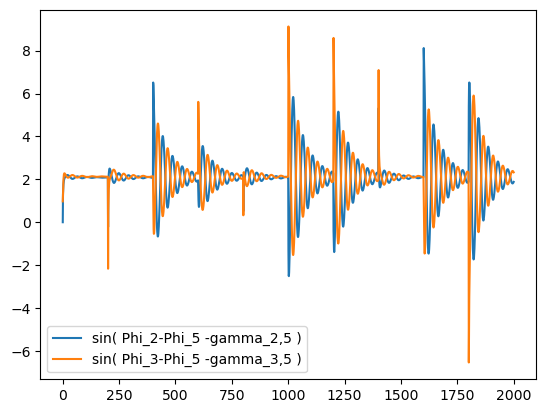

In [164]:
scaled_cand_lib[feature_to_libr_map['P_5']].plot()

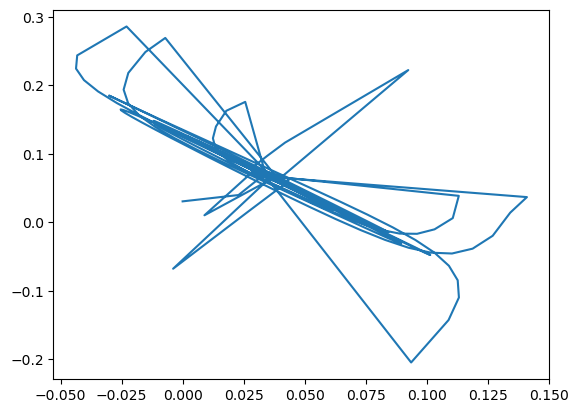

In [165]:
plt.plot(candidate_lib['sin( Phi_2-Phi_5 -gamma_2,5 )'], candidate_lib['sin( Phi_3-Phi_5 -gamma_3,5 )'])

## Finding the dynamic equation for generators

### Refined candidate library is able to find the model 

In [64]:
from sklearn.linear_model import Lasso

alg_lasso = Lasso(fit_intercept=True, alpha=0.3)
alg_lasso.fit(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
alg_lasso.score(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

0.993372962219676

In [66]:
coef_dict = dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))
coef_dict

{'Phi_0': -0.0,
 'Phi_1': 0.0,
 'Phi_2': -0.0,
 'Phi_3': -0.0,
 'Phi_4': -0.0,
 'Phi_5': -0.0,
 'om_0': -4.378569736500431,
 'om_1': 0.0,
 'P_0': -21.257906402869075,
 'P_1': 0.0,
 'P_2': -0.6586577243676952,
 'P_3': -0.0,
 'P_4': 0.0,
 'P_5': 0.0}

In [67]:
seq_th_model.intercept_

43.934898759814715

In [68]:
non_zero_feat = [feat for feat, coef in coef_dict.items() if abs(coef) > 0.01]
non_zero_feat

['om_0', 'P_0', 'P_2']

In [69]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])
lin_model.score(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])

0.9941958733407162

In [70]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'om_0': -4.794440359929478,
 'P_0': -21.691899870238316,
 'P_2': -1.032076931283162}

### Full candidate library is unable to find the model 

In [42]:
alg_lasso.fit(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
alg_lasso.score(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

0.9942246455235572

In [43]:
dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))

{'Phi_0': -0.0,
 'Phi_1': 0.0,
 'Phi_2': -0.0,
 'Phi_3': -0.0,
 'Phi_4': -0.0,
 'Phi_5': -0.0,
 'om_0': -4.42511229895725,
 'om_1': 0.0,
 'P_0': -16.11820529841526,
 'P_1': 0.0,
 'P_2': 0.0,
 'P_3': -0.0,
 'P_4': 0.0,
 'P_5': -0.0,
 'sin( Phi_0-Phi_1 -gamma_0,1 )': -0.0,
 'sin( Phi_0-Phi_2 -gamma_0,2 )': -0.07085153655901995,
 'sin( Phi_0-Phi_3 -gamma_0,3 )': -0.0,
 'sin( Phi_0-Phi_4 -gamma_0,4 )': -1.8898225265120703,
 'sin( Phi_0-Phi_5 -gamma_0,5 )': -3.234378209313293,
 'sin( Phi_1-Phi_2 -gamma_1,2 )': 0.0,
 'sin( Phi_1-Phi_3 -gamma_1,3 )': 0.0,
 'sin( Phi_1-Phi_4 -gamma_1,4 )': 0.0,
 'sin( Phi_1-Phi_5 -gamma_1,5 )': 0.0,
 'sin( Phi_2-Phi_3 -gamma_2,3 )': -0.0,
 'sin( Phi_2-Phi_4 -gamma_2,4 )': -0.0,
 'sin( Phi_2-Phi_5 -gamma_2,5 )': -0.0,
 'sin( Phi_3-Phi_4 -gamma_3,4 )': 0.0,
 'sin( Phi_3-Phi_5 -gamma_3,5 )': 0.0,
 'sin( Phi_4-Phi_5 -gamma_4,5 )': 0.0}

# Using Sequential Thresholding

## Finding the conservation laws

In [227]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

lin_reg_model = LinearRegression
lin_reg_model_arg = {"fit_intercept": True}
seq_th_model = sequentialThLin(custom_model=True,
                               custom_model_ob = lin_reg_model,
                               custom_model_arg= lin_reg_model_arg,
                              coef_threshold=0.1)
# seq_th_model = sequentialThLin(coef_threshold=0.1, fit_intercept=True)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

In [228]:
algebraic_model_th.fit(candidate_lib, scale_columns=True,
                       features_to_fit=features_to_fit_,
                       feature_to_library_map=feature_to_libr_map)


Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 0 iterations


AlgModelFinder(custom_model=True,
               custom_model_ob=<dae_finder.sequentialThLin object at 0x1400bdd60>)

In [229]:
#Best 10 models using R2 metrix
algebraic_model_th.best_models()

,P_0,P_1,P_2,P_3,P_4,P_5,Phi_5,Phi_2,Phi_4,Phi_1,Phi_3,Phi_0
Phi_0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN
Phi_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,NaN,0.00000000,1.21776363
Phi_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.65370189,NaN,-0.32189807,0.00000000,-0.74874104,-183.45250681
Phi_3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.10922318,-0.19787028,0.41970398,-16.42725416,NaN,107.86825547
Phi_4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.23707551,-0.17787530,NaN,17.42725567,0.87774497,-36.92009482
Phi_5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,NaN,1.37574407,0.90219551,0.00000000,0.87099418,112.28656366
om_0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
om_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
"sin( Phi_0-Phi_1 -gamma_0,1 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
"sin( Phi_0-Phi_2 -gamma_0,2 )",9.34425815,0.00000000,-9.34425815,0.00000000,0.00000000,NaN,-382671785.60163981,604184106.99981332,1403174888.69422793,-1879181752.36979771,-2058255981.99400544,1579229536.92056179


In [230]:
algebraic_model_th.get_fitted_intercepts()

{'Phi_0': 0.0003568523693067705,
 'Phi_1': -0.0004765785591372645,
 'Phi_2': -8.113977886016049e-05,
 'Phi_3': 8.658228914546069e-05,
 'Phi_4': -0.00019795206517822509,
 'Phi_5': 7.935874456692199e-05,
 'P_0': -1.1650153483637335e-15,
 'P_1': -2.202525056447109e-15,
 'P_2': -2.1191588763157077e-15,
 'P_3': -5.942612230117445e-15,
 'P_4': -8.920646201097392e-15,
 'P_5': -7.235190610764729e-15}

In [236]:
feat = "P_2"
algebraic_model_th.best_models()[feat][abs(algebraic_model_th.best_models()[feat]) > 0.1]

sin( Phi_0-Phi_2 -gamma_0,2 )   -9.34425815
sin( Phi_2-Phi_4 -gamma_2,4 )   19.63992022
sin( Phi_2-Phi_5 -gamma_2,5 )   26.31080491
r2- metric                       1.00000000
Name: P_2, dtype: float64

## Finding the dynamic equation for generators

### Refined candidate library is able to find the model 

In [56]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

# lin_reg_model = LinearRegression
# lin_reg_model_arg = {"fit_intercept": True}
# seq_th_model = sequentialThLin(custom_model=True,
#                                custom_model_ob = lin_reg_model,
#                                custom_model_arg= lin_reg_model_arg,
#                               coef_threshold=0.1)
seq_th_model = sequentialThLin(model_id="lasso", coef_threshold=0.1, fit_intercept=True)

seq_th_model.fit(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
seq_th_model.score(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

Sequential threshold converged in 1 iterations


0.9861173018370403

In [57]:
coef_dict = dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))
coef_dict

{'Phi_0': 0.0,
 'Phi_1': 0.0,
 'Phi_2': 0.0,
 'Phi_3': 0.0,
 'Phi_4': 0.0,
 'Phi_5': 0.0,
 'om_0': -3.4265790184989955,
 'om_1': 0.0,
 'P_0': -20.273842484145458,
 'P_1': 0.0,
 'P_2': 0.0,
 'P_3': 0.0,
 'P_4': 0.0,
 'P_5': 0.0}

In [58]:
seq_th_model.intercept_

43.67131166721149

In [59]:
non_zero_feat = [feat for feat, coef in coef_dict.items() if abs(coef) > 0.01]
non_zero_feat

['om_0', 'P_0']

In [60]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])
lin_model.score(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])

0.991855949164572

In [61]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'om_0': -4.706282780743189, 'P_0': -21.55353230528021}

### Full candidate library is unable to find the model 

In [62]:
seq_th_model.fit(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
seq_th_model.score(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

Sequential threshold converged in 2 iterations


0.988885520759928

In [63]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'Phi_0': 0.0,
 'Phi_1': 0.0,
 'Phi_2': 0.0,
 'Phi_3': 0.0,
 'Phi_4': 0.0,
 'Phi_5': 0.0,
 'om_0': -3.513639923413333,
 'om_1': 0.0,
 'P_0': -16.19834499489593,
 'P_1': 0.0,
 'P_2': 0.0,
 'P_3': 0.0,
 'P_4': 0.0,
 'P_5': 0.0,
 'sin( Phi_0-Phi_1 -gamma_0,1 )': 0.0,
 'sin( Phi_0-Phi_2 -gamma_0,2 )': 0.0,
 'sin( Phi_0-Phi_3 -gamma_0,3 )': 0.0,
 'sin( Phi_0-Phi_4 -gamma_0,4 )': -1.3982756870160125,
 'sin( Phi_0-Phi_5 -gamma_0,5 )': -2.7962471849994524,
 'sin( Phi_1-Phi_2 -gamma_1,2 )': 0.0,
 'sin( Phi_1-Phi_3 -gamma_1,3 )': 0.0,
 'sin( Phi_1-Phi_4 -gamma_1,4 )': 0.0,
 'sin( Phi_1-Phi_5 -gamma_1,5 )': 0.0,
 'sin( Phi_2-Phi_3 -gamma_2,3 )': 0.0,
 'sin( Phi_2-Phi_4 -gamma_2,4 )': 0.0,
 'sin( Phi_2-Phi_5 -gamma_2,5 )': 0.0,
 'sin( Phi_3-Phi_4 -gamma_3,4 )': 0.0,
 'sin( Phi_3-Phi_5 -gamma_3,5 )': 0.0,
 'sin( Phi_4-Phi_5 -gamma_4,5 )': 0.0}